<div style="border-left: 6px solid #00356B; padding-left: 15px; margin-bottom: 20px;">
  <h1 style="margin-bottom: 5px; color: #00356B"><strong>Assignment 2:</strong> Part 1 (Feed Analysis)</h1>
  <span style="font-size: 1.2em; color: #444; font-weight: bold">S&DS 5350 | Social Algorithms</span>
  <br><br>
  <strong>Primary:</strong> Cailey Bobadilla (cjb239)
  <br>
  <strong>Partner:</strong> Brandon Tran (bat53)
</div>

---

*Mood for this part:*

<iframe data-testid="embed-iframe" style="border-radius:12px" src="https://open.spotify.com/embed/track/6NEoeBLQbOMw92qMeLfI40?utm_source=generator&theme=0" width="40%" height="152" frameBorder="0" allowfullscreen="" allow="autoplay; clipboard-write; encrypted-media; fullscreen; picture-in-picture" loading="lazy"></iframe>

#### AI Acknowledgement

I used Gemini 3 Pro to develop this Jupyter notebook. For parts I.1 and I.2, I used the LLM to accelerate the implementation of my own logic and to verify my understanding of the recommendation system algorithm. For part I.3, I used the LLM to help apply hierarchical clustering for ordering the senators and create the heatmaps for the follow and post Jaccard similarities.

In [ ]:
%pip install ssl

In [23]:
import ssl

# SSL error fix tells Python to ignore certificate errors
ssl._create_default_https_context = ssl._create_unverified_context

When a senator opens Bluesky, they see a reverse-chronological feed of posts from accounts they follow. This feed represents their information environment on the platform.

#### I.1 Data Collection

Write code to collect the feed for each senator:

1. For each senator, retrieve the **list of accounts they follow** using `getFollows`
2. For **each account in that follow list**, fetch that account's posts from the last 24 hours using `getAuthorFeed`
3. Combine these posts into a single reverse-chronological feed for each senator
4. Save the data as JSON (one file per senator, or one combined file)

Note: Look ahead at Section I.3. You’ll need to track both the follow relationships and the posts (for computing Jaccard similarities). Consider saving follow data and feed data separately.

**API endpoints** (see `bluesky_helpers.py` for wrapper functions):

- `app.bsky.graph.getFollows` — list of followed accounts (paginated, up to 100 per request)
- `app.bsky.feed.getAuthorFeed` — recent posts from an account

For API documentation see: Bluesky API documentation

**Rate limits**: Add `time.sleep(0.1)` between requests. The public API allows ~3,000 requests per 5 minutes.

In [ ]:
%pip install time

In [ ]:
import time
import bluesky_helpers

In [ ]:
# Load the list of senators from the senators_bluesky.csv
senators = bluesky_helpers.load_senators('data/senators_bluesky.csv')

# Iterate through each senator
for senator in senators:
    # Get the handle of the current senator
    senator_handle = senator['handle']

    # ========================================================================
    # 1. For each senator, retrieve the list of accounts they follow using 
    #    getFollows
    # ========================================================================

    # Get the list of accounts the current senator follows
    follows_list = bluesky_helpers.get_all_follows(senator_handle)

    # ========================================================================
    # 2. For each account in that follow list, fetch that account's posts from 
    #    the last 24 hours using getAuthorFeed
    # ========================================================================

    # Collect the posts from each of the accounts the current senator follows
    raw_feed_posts = []

    # Iterate through each account the current senator follows
    for i, followed_account in enumerate(follows_list):
        # Get the handle of the current followed account
        followed_handle = followed_account['handle']

        # Get the recent posts for the current account
        result = bluesky_helpers.get_author_feed(followed_handle, limit=50)

        # Need to add between requests (publi ACI allows ~3,000 requests per 5 
        # minutes)
        time.sleep(0.1)

        # Check if the recent posts from the current account actually contain a
        # list of posts
        # NOTE: We check if recent_posts is in recent_posts because 
        # get_author_feed() can return None if the account no longer exists
        if result and 'feed' in result:
            # Iterate through each post from the feed
            for item in result['feed']:
                # Get the post from the feed
                post = item['post']

                # Get the time the post was posted
                created_at = post['record']['createdAt']

                # Check if the post was posted within the last 24 hours
                if bluesky_helpers.is_within_hours(created_at, hours=24):
                    # If it is, then add the current post to the list of posts 
                    # for the current senator
                    raw_feed_posts.append(post)

    # ========================================================================
    # 3. Combine these posts into a single reverse-chronological feed for each 
    #    senator
    # ========================================================================

    # Sort the posts from the current senator's feed in reverse-chronological
    # order
    # NOTE: The time is in ISO format, raw_feed_posts is a list of dictionaries
    # so the key uses the lambda function to extract the exact things to order 
    # by
    sorted_feed = sorted(
        raw_feed_posts, 
        key=lambda x: x['record']['createdAt'],
        reverse=True
    )

    # ========================================================================
    # 4. Save the data as JSON (one file per senator, or one combined file)
    # ========================================================================

    # Save the followed account and reverse-chronological feed for the current 
    # senator
    # NOTE: follows is a separate category for computing Jaccard similarities in
    # I.3
    senator_data = {
        'senator_info': senator, 
        'follows': follows_list, 
        'feed': sorted_feed
    }

    # Define the file name for the current senator's json file
    filename = f'part1_data/{senator_handle}_feed_data.json'

    # Save the current senator's data to the json file
    bluesky_helpers.save_json(senator_data, filename)

#### I.2 "Senators You May Know" Recommendations

Build a simple recommendation system to suggest which senators each senator should follow, based on the follow graph among senators. Use a **triangle-counting** approach: for each senator X who doesn’t follow senator Y, count how many senators that X *does* follow also follow Y. This is the "mutual follows" count — the more senators in X’s network who follow Y, the stronger the recommendation.

`recommendation_score(A, B) = |{C : A follows C and C follows B}|`

This is analogous to main feature in "people you may know" recommendations on various social networks.

Task 

For each senator:

1. Identify which other senators they do **not** currently follow
2. For each non-followed senator, compute the recommendation score (number of followed senators who follow them)
3. Report the **top 3 recommendations** with their scores

If a senator already follows all other senators, note this in your output. If a senator follows no other senators, note this in your output.

In [ ]:
%pip install json
%pip install pandas

In [ ]:
import json
import pandas as pd
import bluesky_helpers

In [ ]:
# Load the list of senators from senators_bluesky.csv
senators = bluesky_helpers.load_senators('data/senators_bluesky.csv')

# Get the handles for all of the senators
all_senator_handles = set([s['handle'] for s in senators])

# Build a graph of which senators follow which senators using a dictionary
# NOTE: The dictionary will have the format {'sen_A': {'sen_B', 'sen_C'}}
senator_follows_graph = {}

# ============================================================================
# 1. Identify which other senators they do not currently follow
# ============================================================================

# Iterate through each senator
for senator in senators:
    # Get the handle of the current senator
    senator_handle = senator['handle']

    # Store the path to the saved json file for this senator
    filename = f'part1_data/{senator_handle}_feed_data.json'

    # Get the data from the current senator's json file
    with open(filename, 'r') as f:
        data = json.load(f)

        # Get the list of all accounts the current senator follows
        all_follows = data.get('follows', [])

        # Set of senator handles to make it quicker to lookup who the current 
        # senator follows
        followed_senators = set()

        # Iterate through all of the accounts the current senator follows
        for account in all_follows:
            # Get the handle of the current account
            account_handle = account.get('handle')

            # Check if that account handle belongs to a senator
            if account_handle in all_senator_handles: 
                # If it does, then add it to the list
                followed_senators.add(account_handle)

        # Add all of the senators that the current senator follows to the graph
        senator_follows_graph[senator_handle] = followed_senators

In [11]:
# ============================================================================
# 2. For each non-followed senator, compute the recommendation score (number 
#    of followed senators who follow them)
# ============================================================================

# List that will store the senator and their top 3 recommendations
results = []

# Dictionary that will contains senators that meet any of the conditions
special_notes = {
    'follows_all': [],
    'follows_zero': [],
    'followed_by_all': [],
    'followed_by_zero': []
}

# Calculate the number of accounts following each senator
followed_by_counts = {h: 0 for h in all_senator_handles}

# Iterate through all of senators (followers) and the set of people they follow
for follower, following_set in senator_follows_graph.items():
    # Iterate through each person they follow
    for followed in following_set: 
        # Add one to the followed by count (number of people who follows them) 
        # for that senator
        followed_by_counts[followed] += 1

# Iterate through each senator
for A in senators:
    # Get the current senator's handle and name
    a_handle = A['handle']
    a_name = A['name']

    # Get the set of people senator A currently follows
    following_set = senator_follows_graph.get(a_handle, set())

    # Check if senator A follows all of the senators
    # NOTE: We need to do -1 because a senator cannot follow themself
    if len(following_set) == len(all_senator_handles) - 1:
        # Add senator A to the follows all list
        special_notes['follows_all'].append(a_name)

        # Format the response for the output recommendations table
        recs_formatted = ['Follows all senators', '', '']
    # Check if senator A follows no other senators    
    # NOTE: If this happens, there will be no recommendations since they have no
    # mutuals to generate recommendations from
    elif len(following_set) == 0:
        # Add senator A to the follows zero list
        special_notes['follows_zero'].append(a_name)

        # Format the response for the output recommendations table
        recs_formatted = ['Follows zero senators', '', '']
    # If senator A does not meet the conditions above, then scores will be 
    # calculated for the group of senators senator A doesn't follow
    else:
        # List will store the scores for the senators senator A doesn't follow
        scores = []

        # Iterate through each senator
        for B in senators:
            # Get senator B's handle
            b_handle = B['handle']

            # Check if senator A is the same as seator B or if senator A already 
            # follows senator B
            # NOTE: continue skips the rest of the current iteration of the for 
            # loop and immediately goes to the next iteration 
            if a_handle == b_handle or b_handle in following_set:
                continue
            
            # Initialize the score
            # NOTE: score represents the number of senator C's that exists where
            # A follows C and C follows B
            score = 0

            # Iterate through every senator A follows (this will be senator C)
            for c_handle in following_set:
                # Get the set of senators C follows
                c_following_set = senator_follows_graph.get(c_handle, set())

                # Check if B is in C's following set of senators
                if b_handle in c_following_set:
                    # Add one to the score since this meets the recommendation 
                    # score requirements
                    score += 1

            # Check if the score is greater than 0
            if score > 0:
                # Add the name of senator B and their recommendation score for 
                # senator A 
                scores.append((B['name'], score))

        # Sort the scores in descending order 
        # NOTE: A higher score means that senator A and senator B have more 
        # mutuals, index of 1 in scores contains the score for sorting key
        scores.sort(key=lambda x: x[1], reverse=True)

        # List will contain the format the top 3 recommendations for the output 
        # table
        recs_formatted = []

        # Get the top 3 recommendations for senator A
        top_3 = scores[:3]

        # Iterate through the name and score for the top 3 recommendations
        for name, score in top_3:
            # Add them to the formatted recommendations
            recs_formatted.append(f'{name} ({score})')

        # If there are less than 3 top recommendations, add empty strings to the 
        # recommendation format
        while len(recs_formatted) < 3:
            recs_formatted.append('')

    # Add the recommendations as a dictionary to the results list for senator A
    results.append({
        'Senator': a_name,
        'Recommendation 1': recs_formatted[0], 
        'Recommendation 2': recs_formatted[1],
        'Recommendation 3': recs_formatted[2]
    })

# Iterate through the handle and number of accounts following that sentator
for handle, count in followed_by_counts.items():
    # Get the name of the senator from their handle
    # NOTE: next() stops iterating through the for loop once the handle matches
    name = next(s['name'] for s in senators if s['handle'] == handle)

    # Check if the number of accounts following the current senator is the same 
    # as the number of senators on Bluesky
    # NOTE: We need to do -1 because a senator cannot follow themself
    if count == len(all_senator_handles) - 1:
        # Add the senator's name to the followed by all list
        special_notes['followed_by_all'].append(name)
    # Check if the number of accounts following the current senator is 0
    if count == 0:
        # Add the senator's name to the followed by zero list
        special_notes['followed_by_zero'].append(name)

Output

Generate a **table** in your report (programmatically, not by hand) with the following format:

| **Senator** | **Recommendation 1** | **Recommendation 2** | **Recommendation 3** |
| :--- | :--- | :--- | :--- |
| Bernie Sanders | Chuck Schumer (8) | Amy Klobuchar (7) | ... |
| Elizabeth Warren | *follows all senators* | &nbsp; | &nbsp; |
| ... | ... | ... | ... |

The number in parentheses is the recommendation score (mutual follows count).

Additionally, identify:

- Which senators (if any) **follow all** or **follow zero** other senators in the dataset
- Which senators (if any) are **followed by all** or **followed by zero** other senators in the dataset

(Note: patterns in recommendations, network centrality, and disconnected senators are the subject of questions in Section I.4.)

In [15]:
# ============================================================================
# 3. Report the top 3 recommendations with their scores
# ============================================================================

# Create a dataframe using the results from 2 and output the table
df_recs = pd.DataFrame(results)

# Change the indexing in the table to start at 1 instead of 0
df_recs.index = df_recs.index + 1

# Output the table
display(df_recs)

# Separate the list of senators for each of the edge cases
# NOTE: join() takes a list and puts a specific separator between each item
follows_all_str = ', '.join(special_notes['follows_all'])
follows_zero_str = ', '.join(special_notes['follows_zero'])
followed_by_all_str = ', '.join(special_notes['followed_by_all'])
followed_by_zero_str = ', '.join(special_notes['followed_by_zero'])

# Print out the findings from the edge cases
# NOTE: If the list is empty, we print None
print(f'Senators who follow everyone: ' +
      f'{follows_all_str if follows_all_str else 'None'}')
print(f'Senators who follow no one: ' +
      f'{follows_zero_str if follows_zero_str else 'None'}')
print(f'Senators followed by everyone: ' +
      f'{followed_by_all_str if followed_by_all_str else 'None'}')
print(f'Senators followed by no one: ' +
      f'{followed_by_zero_str if followed_by_zero_str else 'None'}')

,Senator,Recommendation 1,Recommendation 2,Recommendation 3
1,Tammy Baldwin,John Fetterman (27),Dick Durbin (13),Jack Reed (12)
2,Patty Murray,Dick Durbin (13),Jack Reed (11),Mazie Hirono (11)
3,Maria Cantwell,Chuck Schumer (22),Chris Murphy (16),Amy Klobuchar (15)
4,Mark Warner,Patty Murray (18),Martin Heinrich (18),Cory Booker (18)
5,Tim Kaine,Mazie Hirono (13),Jeff Merkley (5),Maggie Hassan (4)
6,Bernie Sanders,Follows zero senators,,
7,Sheldon Whitehouse,Elissa Slotkin (17),Jeff Merkley (5),Maggie Hassan (4)
8,Jack Reed,Andy Kim (15),Elissa Slotkin (14),Dick Durbin (13)
9,John Fetterman,Follows zero senators,,
10,Ron Wyden,Elissa Slotkin (15),Mazie Hirono (11),Chris Coons (11)


Senators who follow everyone: None
Senators who follow no one: Bernie Sanders, John Fetterman, Jeff Merkley, Kirsten Gillibrand, Maggie Hassan, Chris Murphy, Mark Kelly
Senators followed by everyone: None
Senators followed by no one: Kirsten Gillibrand


#### I.3 Echo Chamber Analysis

Examine the degree to which senators’ feeds overlap using two complementary measures:

Follow Jaccard Similarity

For each pair of senators, compute the Jaccard similarity of the accounts they follow (all accounts, not just senators):

`Jaccard(A, B) = |follows_A ∩ follows_B| / |follows_A ∪ follows_B|`

This measures overlap in terms of who the senators follow, treating all followed accounts equally regardless of how active they are.

In [ ]:
%pip install json
%pip install pandas
%pip install numpy

In [5]:
import json
import pandas as pd
import numpy as np
import bluesky_helpers

In [6]:
# Create a function that will calculate the Jaccard similarity
def calculate_jaccard(a_set: set, b_set: set) -> float:
    """
    Calculates the Jaccard similary of the accounts each pair of senators 
    follows. Note that this includes all accounts, not just senators. 

    Jaccard(A, B) = |follows_A ∩ follows_B| / |follows_A ∪ follows_B|
    
    Args:
        a_set (set): All accounts senator A follows.
        b_set (set): All accounts senator B follows. 
    
    Returns: 
        float: Calculated Jaccard similarity value. 
    """
    # Checks if both senators follow 0 accounts
    # NOTE: This avoids division by 0 in the Jaccard similarity calculation
    if len(a_set) == 0 and len(b_set) == 0:
        return 0.0
    
    # Find the set of accounts followed by both senators
    intersection = len(a_set.intersection(b_set))
    
    # Find the set of accounts followed by senator A or senator B or both
    union = len(a_set.union(b_set))

    # Return the calculated Jaccard similarity
    return intersection / union
    
# Load the list of senators from senators_bluesky.csv
senators = bluesky_helpers.load_senators('data/senators_bluesky.csv')

# Dictionary will store all of the accounts each senator follows and their feed
senator_data = {}

# Iterate through each senator
for senator in senators:
    # Get the handle of the current senator
    senator_handle = senator['handle']

    # Store the path to the saved json file for this senator
    filename = f'part1_data/{senator_handle}_feed_data.json'

    # Get the data from the current senator's json file
    with open(filename, 'r') as f:
        data = json.load(f)

        # Get the list of all accounts the current senator follows and their 
        # feed
        senator_data[senator_handle] = data

# Get the list of all senator handles
senator_handles = [s['handle'] for s in senators]

# Get the list of all senator names
senator_names = [s['name'] for s in senators]

In [7]:
# ============================================================================
# Follow Jaccard Similarity
# ============================================================================

# Get the number of senator handles
n = len(senator_handles)

# Initialize an empty n x n matrix to store all of the follow Jaccard similarity 
# calculations for each pair of senators
follow_jaccard_matrix = np.zeros((n, n))

# Iterate through each pair of senators
for i in range(n):
    for j in range(n):
        # Get the handles for senators A and B
        a_handle = senator_handles[i]
        b_handle = senator_handles[j]

        # Get the list of accounts senators A and B follow
        a_follows_list = senator_data[a_handle].get('follows', [])
        b_follows_list = senator_data[b_handle].get('follows', [])

        # Convert all of the account handles both senators follow to sets of 
        # strings
        # NOTE: This is done to match up with the input parameters for the 
        # calculate_jaccard() function
        a_follows_set = set(account['handle'] for account in a_follows_list)
        b_follows_set = set(account['handle'] for account in b_follows_list)

        # Calculate the follow Jaccard similarity score for the current pair of 
        # senators
        score = calculate_jaccard(a_follows_set, b_follows_set)

        # Set the location of (i, j) in the matrix to be the calculated score
        follow_jaccard_matrix[i][j] = score

# Convert the matrix to a dataframe to make it easier to display
df_follow_jaccard = pd.DataFrame(
    follow_jaccard_matrix, 
    index=senator_names,
    columns=senator_names
)

# Output the matrix
display(df_follow_jaccard)

,Tammy Baldwin,Patty Murray,Maria Cantwell,Mark Warner,Tim Kaine,Bernie Sanders,Sheldon Whitehouse,Jack Reed,John Fetterman,Ron Wyden,...,Jon Ossoff,Chris Coons,Lisa Blunt Rochester,Chris Murphy,Richard Blumenthal,Michael Bennet,Adam Schiff,Alex Padilla,Mark Kelly,Ruben Gallego
Tammy Baldwin,1.000000,0.543860,0.470588,0.172131,0.068392,0.0,0.091358,0.584906,0.0,0.087404,...,0.049180,0.355932,0.444444,0.0,0.538462,0.595745,0.313725,0.345455,0.000000,0.339623
Patty Murray,0.543860,1.000000,0.500000,0.164062,0.073529,0.0,0.092683,0.525424,0.0,0.086076,...,0.044776,0.323077,0.392157,0.0,0.592593,0.528302,0.303571,0.269841,0.000000,0.305085
Maria Cantwell,0.470588,0.500000,1.000000,0.096774,0.047706,0.0,0.066176,0.452830,0.0,0.061224,...,0.036364,0.377358,0.414634,0.0,0.431373,0.446809,0.363636,0.340000,0.000000,0.361702
Mark Warner,0.172131,0.164062,0.096774,1.000000,0.084890,0.0,0.122768,0.141732,0.0,0.095023,...,0.033058,0.093023,0.125000,0.0,0.175000,0.152542,0.122807,0.125000,0.000000,0.109244
Tim Kaine,0.068392,0.073529,0.047706,0.084890,1.000000,0.0,0.131484,0.064220,0.0,0.104567,...,0.009009,0.047273,0.038889,0.0,0.068646,0.059369,0.040665,0.042048,0.000000,0.032787
Bernie Sanders,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sheldon Whitehouse,0.091358,0.092683,0.066176,0.122768,0.131484,0.0,1.000000,0.096296,0.0,0.161721,...,0.019231,0.055156,0.051980,0.0,0.086420,0.079404,0.056931,0.074257,0.002494,0.053790
Jack Reed,0.584906,0.525424,0.452830,0.141732,0.064220,0.0,0.096296,1.000000,0.0,0.084184,...,0.047619,0.344262,0.395833,0.0,0.673469,0.711111,0.326923,0.288136,0.000000,0.351852
John Fetterman,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ron Wyden,0.087404,0.086076,0.061224,0.095023,0.104567,0.0,0.161721,0.084184,0.0,1.000000,...,0.012500,0.055138,0.046392,0.0,0.085052,0.077720,0.059740,0.064103,0.000000,0.045685


Post Jaccard Similarity

The follow Jaccard treats a dormant account the same as one posting 50 times per day, and doesn’t necessarily reflect similarities in their user experience. To capture similarity in what senators *actually* see, define and compute a suitable Jaccard coefficient over post in their feed in the last 24 hours.

Each of these measures (follow Jaccard, post Jaccard) can be interpreted as similarity measures between the senators. Computing these measures for all the senators in the dataset forms two similarity matrices.

In [8]:
# ============================================================================
# Post Jaccard Similarity
# ============================================================================

# Initialize an empty n x n matrix to store all of the post Jaccard similarity 
# calculations for each pair of senators
post_jaccard_matrix = np.zeros((n, n))

# Iterate through each pair of senators
for i in range(n):
    for j in range(n):
        # Get the handles for senators A and B
        a_handle = senator_handles[i]
        b_handle = senator_handles[j]

        # Get the list of posts senators A and B have in their feeds
        a_feed_list = senator_data[a_handle].get('feed', [])
        b_feed_list = senator_data[b_handle].get('feed', [])

        # Get the uri of each post and store it in a set
        # NOTE: The uri (Unique Resource Identifier) uniquely identifies each 
        # post
        a_feed_set = set(post['uri'] for post in a_feed_list)
        b_feed_set = set(post['uri'] for post in b_feed_list)

        # Calculate the post Jaccard similarity score for the current pair of 
        # senators
        score = calculate_jaccard(a_feed_set, b_feed_set)

        # Set the location of (i, j) in the matrix to be the calculated score
        post_jaccard_matrix[i][j] = score

# Convert the matrix to a dataframe to make it easier to display
df_post_jaccard = pd.DataFrame(
    post_jaccard_matrix, 
    index=senator_names,
    columns=senator_names
)

# Output the matrix
display(df_post_jaccard)

,Tammy Baldwin,Patty Murray,Maria Cantwell,Mark Warner,Tim Kaine,Bernie Sanders,Sheldon Whitehouse,Jack Reed,John Fetterman,Ron Wyden,...,Jon Ossoff,Chris Coons,Lisa Blunt Rochester,Chris Murphy,Richard Blumenthal,Michael Bennet,Adam Schiff,Alex Padilla,Mark Kelly,Ruben Gallego
Tammy Baldwin,1.000000,0.119149,0.114130,0.388759,0.150854,0.0,0.124294,0.138122,0.0,0.071388,...,0.000000,0.080645,0.103825,0.0,0.120219,0.128492,0.069149,0.440860,0.0,0.063830
Patty Murray,0.119149,1.000000,0.217391,0.173709,0.076923,0.0,0.062092,0.255556,0.0,0.041356,...,0.281250,0.125000,0.224719,0.0,0.272727,0.238636,0.148936,0.060606,0.0,0.082759
Maria Cantwell,0.114130,0.217391,1.000000,0.037559,0.020173,0.0,0.018033,0.617647,0.0,0.012111,...,0.000000,0.428571,0.378378,0.0,0.500000,0.593750,0.282051,0.125000,0.0,0.164706
Mark Warner,0.388759,0.173709,0.037559,1.000000,0.240376,0.0,0.230189,0.047281,0.0,0.130871,...,0.119247,0.030588,0.045238,0.0,0.052381,0.042755,0.035461,0.185446,0.0,0.040598
Tim Kaine,0.150854,0.076923,0.020173,0.240376,1.000000,0.0,0.270469,0.024085,0.0,0.157520,...,0.052871,0.018287,0.021215,0.0,0.025097,0.022201,0.018287,0.081731,0.0,0.012809
Bernie Sanders,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Sheldon Whitehouse,0.124294,0.062092,0.018033,0.230189,0.270469,0.0,1.000000,0.021364,0.0,0.214109,...,0.057007,0.011438,0.013912,0.0,0.021382,0.018914,0.013923,0.071429,0.0,0.032077
Jack Reed,0.138122,0.255556,0.617647,0.047281,0.024085,0.0,0.021364,1.000000,0.0,0.014443,...,0.000000,0.378378,0.368421,0.0,0.718750,0.857143,0.307692,0.123810,0.0,0.176471
John Fetterman,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Ron Wyden,0.071388,0.041356,0.012111,0.130871,0.157520,0.0,0.214109,0.014443,0.0,1.000000,...,0.044068,0.008060,0.009798,0.0,0.015038,0.013302,0.009804,0.050260,0.0,0.012943


Visualization and analysis

1. Create **two heatmaps**: one for follow Jaccard similarity, one for post Jaccard similarity. You may present these as two separate figures or side-by-side in a single figure for easy comparison.
2. **Sort the rows and columns** so that similar senators are adjacent. Use hierarchical clustering to determine the ordering (see `scipy.cluster.hierarchy.linkage` and `dendrogram`), or (if you want to explore alternative visualization techniques) explore some other sorting algorithm. An unsorted heatmap with arbitrary row/column order is much harder to interpret — clusters appear scattered rather than as visible blocks along the diagonal. Use the same ordering for both heatmaps to enable direct comparison.
3. **Compare and contrast the two matrices**: What do they show? Interpret any clustering patterns you see. Where do the two matrices differ? Senators with similar follows but different posts might follow the same accounts but experience very different information environments based on posting frequency.

In [2]:
%pip install seaborn
%pip install matplotlib
%pip install matplotlib-inline
%pip install scipy

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numpy-2.4.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (6.6 kB)
  Using cached pandas-3.0.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (79 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-12.1.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

In [9]:
# ============================================================================
# 2. Sort the rows and columns so that similar senators are adjacent. 
# ============================================================================

# Create the distance matrix
# NOTE: Hierarchical clustering requires distance (opposite of similarity)
distance_matrix = 1 - df_follow_jaccard.values

# Fill all diagonal values in the matrix with 0 (distance to oneself is 0)
np.fill_diagonal(distance_matrix, 0)

# Convert the distance matrix to a condensed form so linkage knows these are 
# pairwise distances
# NOTE: This is required for clustering to use the Jaccard values correctly
condensed_dist = squareform(distance_matrix)

# Compute the linkage/clustering
# NOTE: method='ward' minimizes variance by creating tight clusters
Z = linkage(condensed_dist, method='ward')

# Get the sorting order using dendrogram
dendrogram_order = dendrogram(Z, no_plot=True)

# Get the sorted indices using the leaves key
sorted_indices = dendrogram_order['leaves']

# Use the sorted indices to get the sorted list of names 
sorted_labels = [df_follow_jaccard.index[i] for i in sorted_indices]

# Reorder the follows and posts dataframes based on the new labels
df_follow_sorted = df_follow_jaccard.loc[sorted_labels, sorted_labels]
df_post_sorted = df_post_jaccard.loc[sorted_labels, sorted_labels]

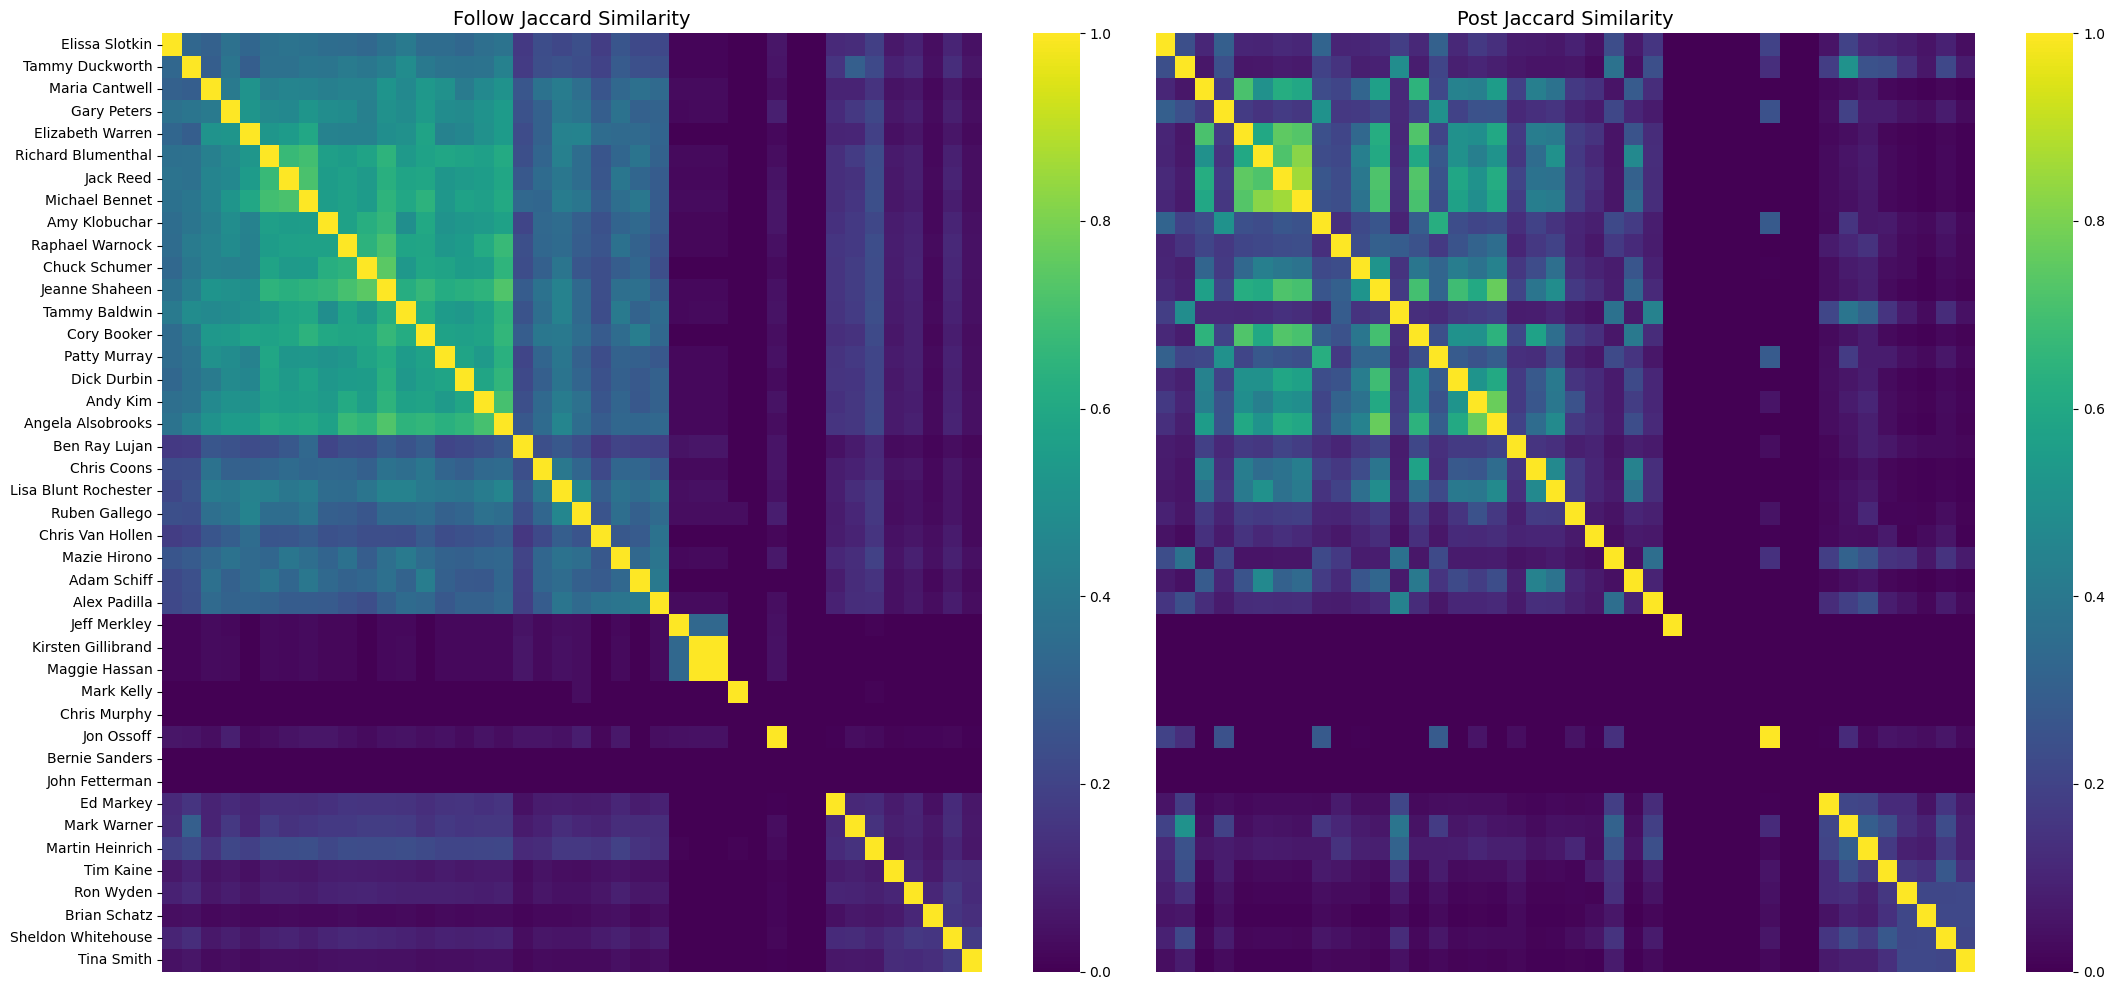

In [10]:
# ============================================================================
# 1. Create two heatmaps: one for follow Jaccard similarity, one for post 
#    Jaccard similarity. 
# ============================================================================

# Initialize a figure that will contain the two heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

# Create the heatmap for follow Jaccard similarity
sns.heatmap(
    df_follow_sorted,
    ax=ax1,
    cmap='viridis',
    xticklabels=False,
    yticklabels=True
)
ax1.set_title('Follow Jaccard Similarity', fontsize=14)

# Create the heatmap for post Jaccard similarity
sns.heatmap(
    df_post_sorted,
    ax=ax2,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False
)
ax2.set_title('Post Jaccard Similarity', fontsize=14)

plt.tight_layout()
plt.show()

**Suggested questions to consider** (you don’t need to answer all or any of these, but they may guide your interpretation): Do senators from the same state follow similar accounts? Do female senators follow systematically different accounts than male senators? Are there identifiable “information bubbles”? How does weighting by post volume change the similarity structure?